In [39]:
! pip install Pandas 


In [40]:
import pandas as pd

df = pd.read_csv("online_shoppers_intention.csv")

print(df)

       Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000 

In [41]:
print(df.describe())


       Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.00000

In [42]:
import plotly.express as pt
import numpy

browser_counts = df['Browser'].value_counts()
top_5_browsers = browser_counts.head(5)
others = browser_counts.tail(-5).sum()
if others > 0:
    top_5_browsers['Others'] = others

fig = pt.pie(values=top_5_browsers.values, names=top_5_browsers.index,
            title='Browser Distribution (Top 5 + Others)')
fig.show()


In [43]:

browser_13 = df[df['Browser'] == 13]
others = df[df['Browser'] != 13]

characteristics = {
    'Revenue_True': (browser_13['Revenue'].mean() * 100, others['Revenue'].mean() * 100),
    'Returning_Visitor': ((browser_13['VisitorType'] == 'Returning_Visitor').mean() * 100,
                         (others['VisitorType'] == 'Returning_Visitor').mean() * 100),
    'Weekend_Shopping': (browser_13['Weekend'].mean() * 100, others['Weekend'].mean() * 100),
    
    
}


import plotly.graph_objects as pg
fig = pg.Figure(data=[
    pg.Bar(name='Browser 13', x=list(characteristics.keys()), 
           y=[v[0] for v in characteristics.values()]),
    pg.Bar(name='Other Browsers', x=list(characteristics.keys()), 
           y=[v[1] for v in characteristics.values()])
])
fig.update_layout(barmode='group', title='Browser 13 vs Others:Characteristics')
fig.show()

In [44]:
import plotly.express as px
df_copy=df.copy()
df_copy['Browser_group']=df_copy['Browser'].apply(lambda x: 'Browser 13' if x ==13 else 'Other browsers')
summary = df_copy.groupby("Browser_group")["Revenue"].mean().reset_index()
fig = px.bar(summary, x="Browser_group", y="Revenue", labels={"Revenue": "Purchase Rate"})
fig.show()

In [54]:
from sklearn.preprocessing import StandardScaler
X=df.copy()
X= X.drop(columns=['Revenue'])
X=pd.get_dummies(X,columns=['Month', 'VisitorType'], drop_first=True)
X["Weekend"]=X["Weekend"].astype(int)
X = X.astype(float, errors="ignore")
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

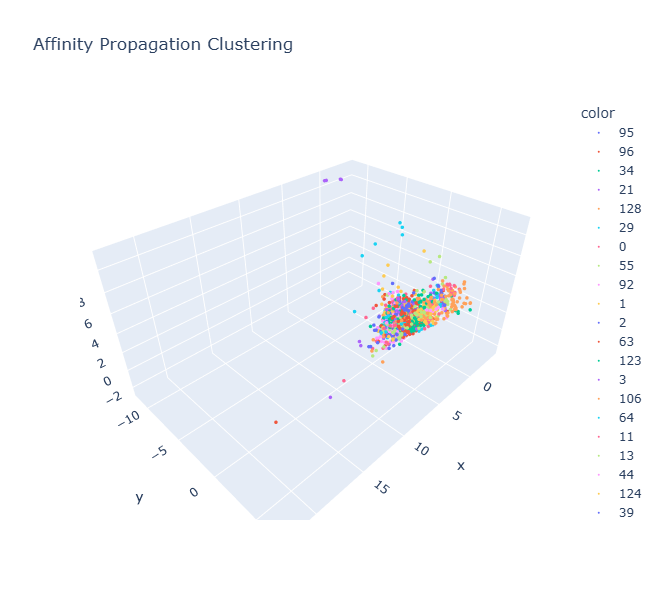

In [64]:
from sklearn.cluster import AffinityPropagation, DBSCAN, Birch
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=3)
X_pca=pca.fit_transform(X_scaled)
#Seed for random selection to use the same selection in every run
np.random.seed(42)
#Sample of data points to cut down on the runtime of the program
sample_x=np.random.choice(len(X_scaled), size=2000, replace=False)

X_scaled_sample=X_scaled[sample_x]
X_pca_sample=X_pca[sample_x]

ap=AffinityPropagation(random_state=42)
ap_labels = ap.fit_predict(X_scaled_sample)

fig_ap= px.scatter_3d(x=X_pca_sample[:,0], y=X_pca_sample[:,1], z=X_pca_sample[:,2], color=ap_labels.astype(str), title="Affinity Propagation Clustering")
fig_ap.update_traces(marker=dict(size=2))   # try 1, 2, or 3 for thinner points

fig_ap.update_layout(width=800, height=600)
fig_ap.show()

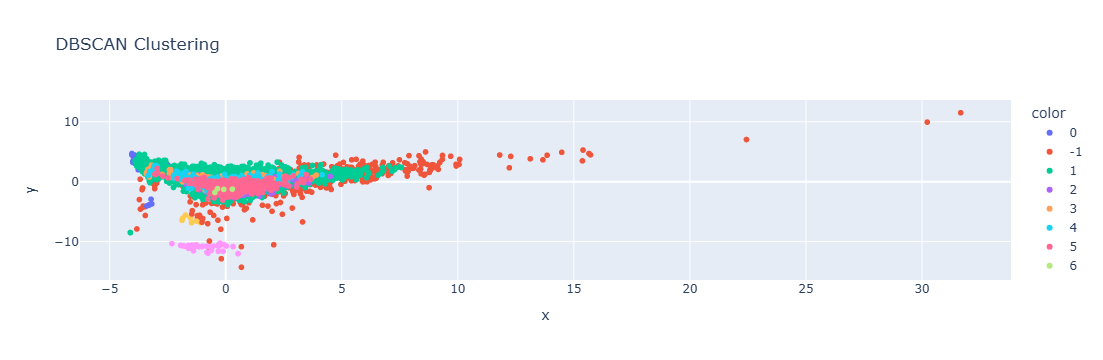

In [57]:
db=DBSCAN(eps=3, min_samples=5)
db_labels=db.fit_predict(X_scaled_sample)

fig_db= px.scatter(x=X_pca_sample[:,0], y=X_pca_sample[:,1], color=db_labels.astype(str), title="DBSCAN Clustering",width=800,height=400)
fig_db.show()

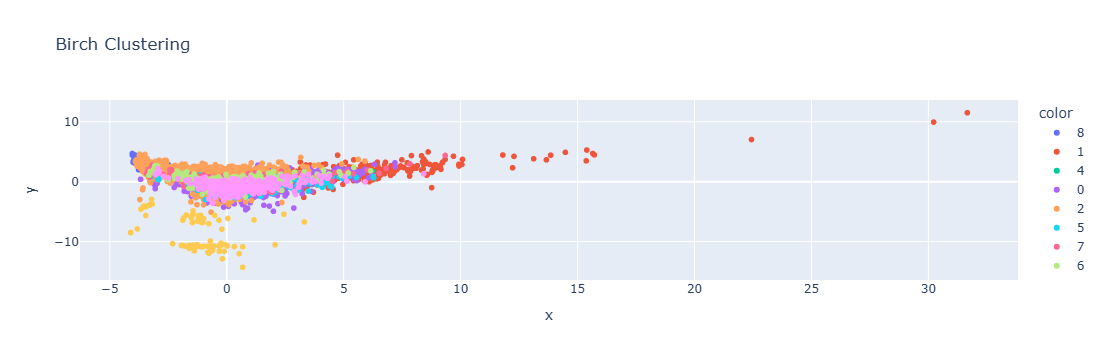

In [58]:
birch = Birch(n_clusters=3)
birch_labels = birch.fit_predict(X_scaled_sample)

fig_birch=px.scatter(x=X_pca_sample[:,0],y=X_pca_sample[:,1],color=birch_labels.astype(str), title="Birch Clustering")
fig_birch.show()

In [66]:
import numpy as np
from sklearn.metrics import silhouette_score

def distance(p1, p2):
    return np.sqrt(sum((a-b)**2 for a,b in zip(p1,p2)))

def my_silhouette_score(X,labels):
    n=len(X)
    silhouettes=[]
    unique_clusters=set(labels)
# Loop for the silhouette score
    for i in range(n):
        same_cluster = [j for j in range(n) if labels[j] == labels[i] and j != i]
        #When points are in same cluster, a_i is the average distance to other points in its cluster
        if same_cluster:
            a_i=sum(distance(X[i],X[j]) for j in same_cluster)/len(same_cluster)
        else: a_i=0

        b_i=math.inf
        #Loop over all clusters except the cluster i is in
        for cluster in unique_clusters:
            if cluster == labels[i]:
                continue
            other_clusters = [j for j in range(n) if labels[j] == cluster]
            if other_clusters:
                #Average distance from i to points in this cluster
                avg_dist=sum(distance(X[i],X[j]) for j in other_clusters)/len(other_clusters)
                b_i=min(b_i,avg_dist)
        #formula: s_i = (b_i - a_i) / max(a_i, b_i)
        if max(a_i,b_i)>0:
            s_i=(b_i-a_i)/max(a_i,b_i)
        #edge case: if both a_i and b_i are 0
        else: s_i=0
        silhouettes.append(s_i)
    #Return mean silhouette score across all samples
    return sum(silhouettes)/len(silhouettes)


# print(my_silhouette_score(X_pca_sample,ap_labels))
# print(my_silhouette_score(X_pca_sample,db_labels))
# print(my_silhouette_score(X_pca_sample,birch_labels))
print(silhouette_score(X_pca_sample,ap_labels))
print(silhouette_score(X_pca_sample,db_labels))
print(silhouette_score(X_pca_sample,birch_labels))

-0.1975789169133229


ValueError: Found input variables with inconsistent numbers of samples: [2000, 12330]

In [68]:
from sklearn.metrics import davies_bouldin_score

print(davies_bouldin_score(X_pca_sample,ap_labels))
print(davies_bouldin_score(X_pca_sample,db_labels))
print(davies_bouldin_score(X_pca_sample,birch_labels))

4.9970913597954265


ValueError: Found input variables with inconsistent numbers of samples: [2000, 12330]

In [76]:
from sklearn.metrics import calinski_harabasz_score

print(calinski_harabasz_score(X_pca_sample,ap_labels))
print(calinski_harabasz_score(X_pca_sample,db_labels))
print(calinski_harabasz_score(X_pca_sample,birch_labels))

84.25198655740424


ValueError: Found input variables with inconsistent numbers of samples: [2000, 12330]

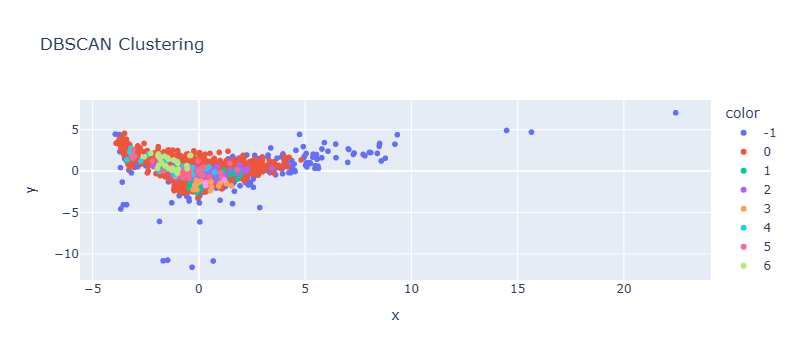

In [70]:
def euclidean_distance(p1,p2):
    sum_squared=0
    #Loop to calculate the sum squared of two different points.
    for i in range(len(p1)):
        sum_squared+=(p1[i]-p2[i])**2
    #Taking the squareroot of the sum squared to calculate euclidian distance
    return sum_squared**0.5


db=DBSCAN(eps=3, min_samples=5, metric=euclidean_distance)
db_labels_eucl=db.fit_predict(X_scaled_sample)

fig_db= px.scatter(x=X_pca_sample[:,0], y=X_pca_sample[:,1], color=db_labels_eucl.astype(str), title="DBSCAN Clustering")
fig_db.show()

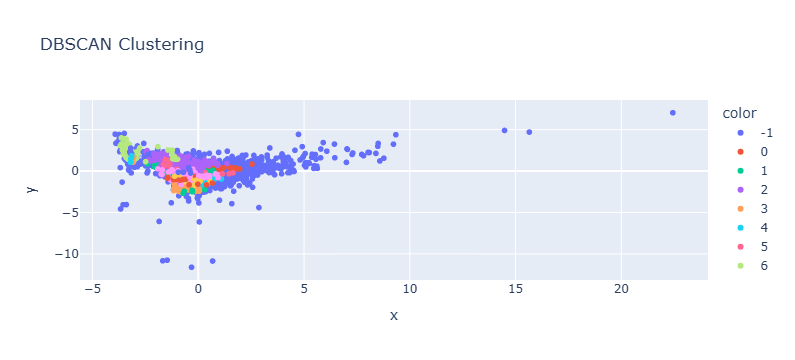

In [71]:
def manhattan_distance(p1,p2):
    total=0
    #Loop to calculate the difference between two points. Difference is added to total every iteration
    for i in range(len(p1)):
        diff=p1[i]-p2[i]
        if diff<0:
            diff =-diff
        total+=diff
    return total

db=DBSCAN(eps=3, min_samples=5, metric=manhattan_distance)
db_labels_manh=db.fit_predict(X_scaled_sample)

fig_db= px.scatter(x=X_pca_sample[:,0], y=X_pca_sample[:,1], color=db_labels_manh.astype(str), title="DBSCAN Clustering")
fig_db.show()

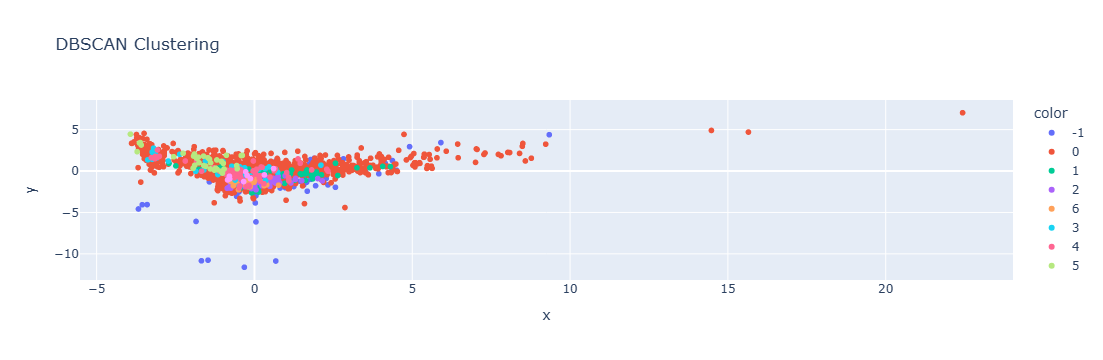

In [72]:
def cosine_distance(p1,p2):
    top=0
    bottom1=0
    bottom2=0
    #Loop to calculate the top and bottom of the fraction
    #bottom 1 and bottom2 are the numbers under the square roots
    for i in range(len(p1)):
        top+=p1[i]*p2[i]
        bottom1+=p1[i]**2
        bottom2+=p2[i]**2
    # similarity is calculated after the loop ends
    cos_similarity=top/((bottom1**0.5)*(bottom2**0.5))
    return 1-cos_similarity


db=DBSCAN(eps=0.2, min_samples=6, metric=cosine_distance)
db_labels_cos=db.fit_predict(X_scaled_sample)

fig_db= px.scatter(x=X_pca_sample[:,0], y=X_pca_sample[:,1], color=db_labels_cos.astype(str), title="DBSCAN Clustering")
fig_db.show()

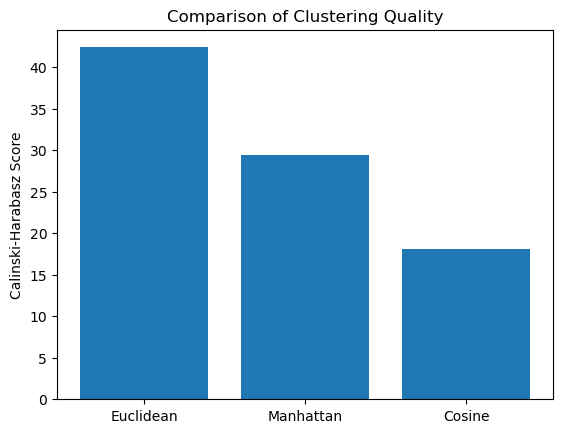

Number of clusters found:
Euclidean: 8
Manhattan: 21
Cosine: 8


In [80]:

import matplotlib.pyplot as plt

scores = {
    "Euclidean": calinski_harabasz_score(X_pca_sample, db_labels_eucl),
    "Manhattan": calinski_harabasz_score(X_pca_sample, db_labels_manh),
    "Cosine": calinski_harabasz_score(X_pca_sample, db_labels_cos),
}

plt.bar(scores.keys(), scores.values())
plt.ylabel("Calinski-Harabasz Score")
plt.title("Comparison of Clustering Quality")
plt.show()

cluster_counts = {
    "Euclidean": len(set(db_labels_eucl)) - (1 if -1 in db_labels_eucl else 0),
    "Manhattan": len(set(db_labels_manh)) - (1 if -1 in db_labels_manh else 0), 
    "Cosine": len(set(db_labels_cos)) - (1 if -1 in db_labels_cos else 0)
}

print("Number of clusters found:")
for method, count in cluster_counts.items():
    print(f"{method}: {count}")